In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

from sklearn.preprocessing import MultiLabelBinarizer
from imblearn.over_sampling import SMOTE
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

# **Data & Pre-processing**

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Masters Thesis/data/attribution_data.csv')
df.head()

,cookie,time,interaction,conversion,conversion_value,channel
0,00000FkCnDfDDf0iC97iC703B,2018-07-03T13:02:11Z,impression,0,0.0,Instagram
1,00000FkCnDfDDf0iC97iC703B,2018-07-17T19:15:07Z,impression,0,0.0,Online Display
2,00000FkCnDfDDf0iC97iC703B,2018-07-24T15:51:46Z,impression,0,0.0,Online Display
3,00000FkCnDfDDf0iC97iC703B,2018-07-29T07:44:51Z,impression,0,0.0,Online Display
4,0000nACkD9nFkBBDECD3ki00E,2018-07-03T09:44:57Z,impression,0,0.0,Paid Search


In [ ]:
df['time'] = pd.to_datetime(df['time'])

In [ ]:
# visit_order per cookie based on time order
df = df.sort_values(['cookie', 'time'], ascending=[False, True])
df['visit_order'] = df.groupby('cookie').cumcount() + 1

In [ ]:
df_paths = df.groupby('cookie')['channel'].aggregate(lambda x: x.tolist()).reset_index()
df_last_interaction = df.drop_duplicates('cookie', keep='last')[['cookie', 'conversion']]
df_paths = pd.merge(df_paths, df_last_interaction, how='left', on='cookie')
df_paths.drop(columns = ['cookie'], inplace = True)

In [ ]:
total_conversions = sum(df_paths['conversion'])
print("No. of conversions: ", total_conversions)

No. of conversions:  17639


In [ ]:
# reference: https://www.geeksforgeeks.org/highlight-the-maximum-value-in-each-column-in-pandas/
def highlight_max_attribution(row, df):
    '''
    highlight the maximum in a Series green.
    '''
    is_max = row.loc['Attributed Credit'] == df['Attributed Credit'].max()
    return ['background-color: lightgreen' if is_max else '' for v in row.index]

# **Feature Engineering & train-test-split & SMOTE**

In [ ]:
# One-hot encode the touchpoints
mlb = MultiLabelBinarizer()
X = mlb.fit_transform(df_paths['channel'])
y = df_paths['conversion']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Apply SMOTE to oversample the minority class
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split the data into training and testing sets
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [ ]:
print("Total no. of instances before sampling:", len(y),
      "\nTotal no. of instances after sampling:", len(y_resampled))

print('\nResampled dataset shape:', Counter(y_resampled))

Total no. of instances before sampling: 240108 
Total no. of instances after sampling: 444938

Resampled dataset shape: Counter({0: 222469, 1: 222469})


In [ ]:
def evaluation_metrics(y_test, y_pred):
  print("Accuracy: ", round(accuracy_score(y_test, y_pred), 2))
  print("AUC score: ", round(roc_auc_score(y_test, y_pred), 2))
  print("\nClassification Report:\n", classification_report(y_test, y_pred))
  print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# **Logistic Regression**

## No Resampling/Class weights

In [ ]:
# Initialize and train a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
evaluation_metrics(y_test, y_pred)

Accuracy:  0.93
AUC score:  0.5

Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96     44455
           1       0.00      0.00      0.00      3567

    accuracy                           0.93     48022
   macro avg       0.46      0.50      0.48     48022
weighted avg       0.86      0.93      0.89     48022


Confusion Matrix:
 [[44455     0]
 [ 3567     0]]


In [ ]:
# Get coefficients from the logistic regression model
coefficients = model.coef_[0]

# Create a DataFrame to map coefficients to channels
feature_names = mlb.classes_
attribution_df = pd.DataFrame({'Channel': feature_names, 'Coefficient': coefficients})

# Calculate attributed credit by normalizing coefficients
attribution_df['Attributed Credit'] = (attribution_df['Coefficient'] / attribution_df['Coefficient'].sum())*total_conversions

# Calculate attributed credit percentage
attribution_df['Attributed Credit %'] = round((attribution_df['Coefficient'] / attribution_df['Coefficient'].sum())*100, 2)
attribution_df['Attributed Credit %'] = attribution_df['Attributed Credit %'].apply(lambda x: f"{x:.2f}%")

# Sort by attributed credit in descending order
# attribution_df = attribution_df.sort_values('Attributed Credit', ascending=False)
attribution_df.style.apply(highlight_max_attribution, df=attribution_df, axis=1)

,Channel,Coefficient,Attributed Credit,Attributed Credit %
0,Facebook,0.308688,3595.023668,20.38%
1,Instagram,0.353811,4120.530113,23.36%
2,Online Display,0.143279,1668.651319,9.46%
3,Online Video,0.553393,6444.899949,36.54%
4,Paid Search,0.155407,1809.894953,10.26%


## Resampling using SMOTE

In [ ]:
# Initialize and train a logistic regression model on the resampled data
model_resampled = LogisticRegression()
model_resampled.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred_resampled = model_resampled.predict(X_test_resampled)

# Evaluate the model trained on resampled data
evaluation_metrics(y_test_resampled, y_pred_resampled)

Accuracy:  0.56
AUC score:  0.56

Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.68      0.60     44453
           1       0.58      0.44      0.50     44535

    accuracy                           0.56     88988
   macro avg       0.56      0.56      0.55     88988
weighted avg       0.56      0.56      0.55     88988


Confusion Matrix:
 [[30068 14385]
 [25024 19511]]


In [ ]:
# Get coefficients from the logistic regression model
coefficients = model_resampled.coef_[0]

# Create a DataFrame to map coefficients to channels
feature_names = mlb.classes_
attribution_df = pd.DataFrame({'Channel': feature_names, 'Coefficient': coefficients})

# Calculate attributed credit by normalizing coefficients
attribution_df['Attributed Credit'] = (attribution_df['Coefficient'] / attribution_df['Coefficient'].sum())*total_conversions

# Calculate attributed credit percentage
attribution_df['Attributed Credit %'] = round((attribution_df['Coefficient'] / attribution_df['Coefficient'].sum())*100, 2)
attribution_df['Attributed Credit %'] = attribution_df['Attributed Credit %'].apply(lambda x: f"{x:.2f}%")

# Sort by attributed credit in descending order
# attribution_df = attribution_df.sort_values('Attributed Credit', ascending=False)
attribution_df.style.apply(highlight_max_attribution, df=attribution_df, axis=1)

,Channel,Coefficient,Attributed Credit,Attributed Credit %
0,Facebook,0.315532,3498.189413,19.83%
1,Instagram,0.379741,4210.048873,23.87%
2,Online Display,0.152718,1693.126558,9.60%
3,Online Video,0.578444,6412.993484,36.36%
4,Paid Search,0.164580,1824.641672,10.34%


## Using Class weights

In [ ]:
# Initialize and train a logistic regression model
model_balanced = LogisticRegression(class_weight='balanced')
model_balanced.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model_balanced.predict(X_test)

# Evaluate the model
evaluation_metrics(y_test, y_pred)

Accuracy:  0.66
AUC score:  0.56

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.68      0.79     44455
           1       0.10      0.44      0.16      3567

    accuracy                           0.66     48022
   macro avg       0.52      0.56      0.47     48022
weighted avg       0.88      0.66      0.74     48022


Confusion Matrix:
 [[30021 14434]
 [ 1982  1585]]


In [ ]:
# Get coefficients from the logistic regression model
coefficients = model_balanced.coef_[0]

# Create a DataFrame to map coefficients to channels
feature_names = mlb.classes_
attribution_df = pd.DataFrame({'Channel': feature_names, 'Coefficient': coefficients})

# Calculate attributed credit by normalizing coefficients
attribution_df['Attributed Credit'] = (attribution_df['Coefficient'] / attribution_df['Coefficient'].sum())*total_conversions

# Calculate attributed credit percentage
attribution_df['Attributed Credit %'] = round((attribution_df['Coefficient'] / attribution_df['Coefficient'].sum())*100, 2)
attribution_df['Attributed Credit %'] = attribution_df['Attributed Credit %'].apply(lambda x: f"{x:.2f}%")

# Sort by attributed credit in descending order
# attribution_df = attribution_df.sort_values('Attributed Credit', ascending=False)
attribution_df.style.apply(highlight_max_attribution, df=attribution_df, axis=1)

,Channel,Coefficient,Attributed Credit,Attributed Credit %
0,Facebook,0.322895,3546.531698,20.11%
1,Instagram,0.361822,3974.093649,22.53%
2,Online Display,0.158673,1742.789989,9.88%
3,Online Video,0.582073,6393.232137,36.24%
4,Paid Search,0.180484,1982.352527,11.24%


# SHAP

References
* https://www.youtube.com/watch?v=L8_sVRhBDLU
* https://www.youtube.com/watch?v=MQ6fFDwjuco
* https://www.youtube.com/watch?v=2xlgOu22YgE&t=50s
* https://towardsdatascience.com/explainable-ai-xai-with-shap-multi-class-classification-problem-64dd30f97cea
* https://christophm.github.io/interpretable-ml-book/shap.html

In [ ]:
!pip install shap
import shap

For logistic regression: https://shap-lrjball.readthedocs.io/en/latest/generated/shap.Explainer.html

In [ ]:
channels = mlb.classes_.tolist()

In [ ]:
# Implement SHAP (SHapley Additive exPlanations)
explainer = shap.Explainer(model_balanced, X_train, feature_names=channels)
shap_values = explainer(X_test)

In [ ]:
shap_values.shape

(48022, 5)

## **Global Interpretability**

To understand the trends the model is using to make predictions in general

 Absolute Mean SHAP - to tell us which features are most important to the model --> average impact on model output magnitude

 each bar gives the absolute mean SHAP value for that feature --> kinda like feature importance but  attribute the contribution of each feature to the prediction for each sample and then averages the value to provide a average magnitude of the impact a feature has on the model's predictions

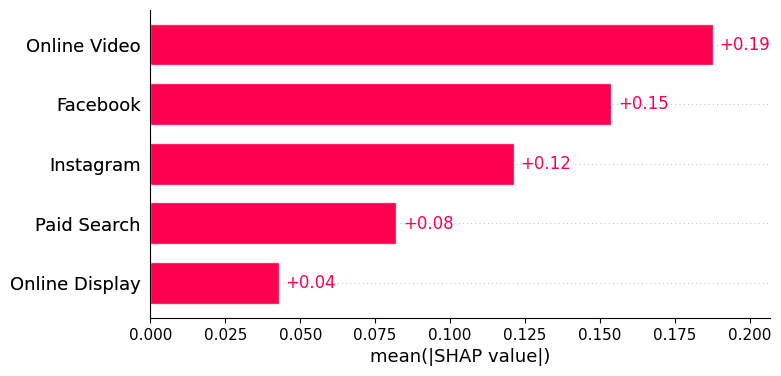

In [ ]:
shap.plots.bar(shap_values)

beeswarm plot - visualisation of all SHAP values

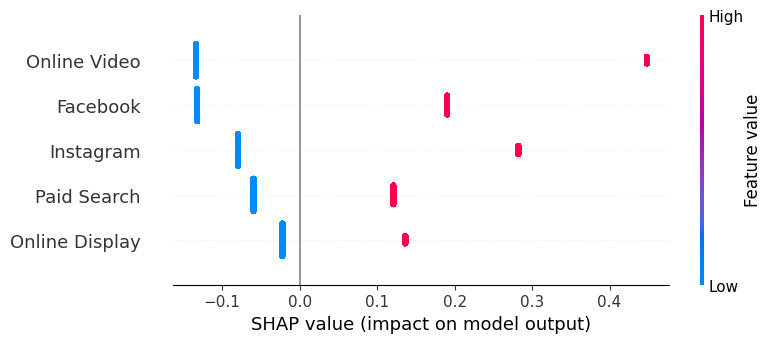

In [ ]:
# Visualize the SHAP values
shap.plots.beeswarm(shap_values)

## **Local Interpretability**

The SHAP waterfall plot and force plot (which is kind of like a condensed waterfall plot) are useful for understanding how the model has made individual predictions

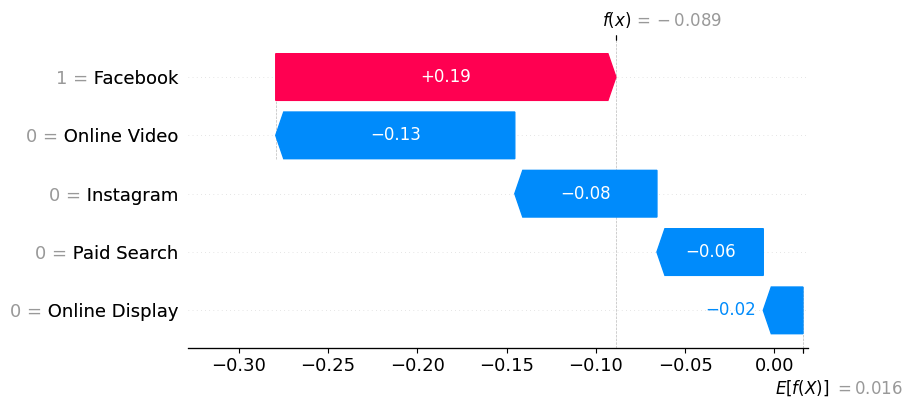

In [ ]:
# E[f(x)] --> average predicted log odds
# f(x) --> predicted log odds for specified instance
row = 10
shap.plots.waterfall(shap_values[row])

In [ ]:
# Represent X_test[row] using mlb.classes_.tolist()
pd.Series(X_test[row], index=channels)

,0
Facebook,1
Instagram,0
Online Display,0
Online Video,0
Paid Search,0


In [ ]:
shap.initjs()
shap.force_plot(shap_values[row], X_test[row])

---